In [1]:
import matplotlib.image as mpimg;import matplotlib.pyplot as plt
import numpy as np;import pickle;import sys as s;import random as rd
import torch;import torch.nn as nn;import torch.optim as optim
from pandas_ods_reader import read_ods
import sys as s

In [2]:
def Get_Dataset_real():# Esse é o nome da função.
    sheet = "sheet_name"
    df = read_ods('data_without_low_data.ods', headers=True)
    sheets=df.keys()
    cells=[];    Y=[];    X=[]
    for i in sheets:
        cells.append(i)
    cells.remove('time')
    o=1
    for i in cells:
        o+=1
        y=np.array(df[i])
        y=y/max(y)
        x=np.linspace(0,len(y),len(y))
        Y.append(y)
        X.append(x)
    #Y=torch.as_tensor(Y)
    print(np.shape(Y))

    address = open("Y_train","wb");    pickle.dump(Y, address);    address.close()
    return Y
Y=Get_Dataset_real()

(44, 145)


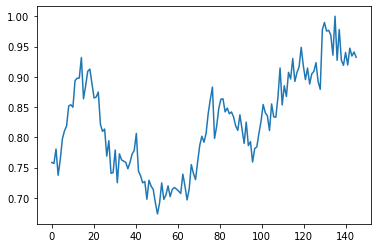

In [16]:
index=rd.randint(0,np.shape(Y)[0])
y=1*Y[index]
x=np.linspace(0,len(y),len(y))
plt.plot(x,y)
plt.show()

## Gera o dataset_1.0

O dataset é composto de $$part_1=[y_0,..,y_{d/2}]$$ with dimension $d/2$ and $$label_1=[0].$$ For the initial part of the graph. Now for the second part of the graph we have $$part_2=[y_{d/2+1},...,y_d]$$ with dimension $d/2$ and with $$label_2=[1].$$

In [4]:
''' Gera o dataset
        O dataset é composto de $part_1=[y_0,..,y_{d/2}]$ with dimension $d/2$ and $label_1=[0]$ For the initial part of the graph.
        For the second part of the graph we have $part_2=[y_{d/2},...,y_d]$ with dimension $d/2$ and with $label_2=[1]$.
'''
def gen_dataset():
    Input=[]
    Output=[]
    Input_test=[]
    Output_test=[]
    j=0
    for i in Y:
        if j<40:

            Y1=i[0:int(np.shape(Y)[1]/2)]
            Input.append(Y1)
            Output.append(0)
            Y2=i[int(np.shape(Y)[1]/2):np.shape(Y)[1]-1]
            Input.append(Y2)
            Output.append(1)
        else:
            Y1=i[0:int(np.shape(Y)[1]/2)]
            Input_test.append(Y1)
            Output_test.append(0)
            Y2=i[int(np.shape(Y)[1]/2):np.shape(Y)[1]-1]
            Input_test.append(Y2)
            Output_test.append(1)
        j+=1
    #---------------------- Salva o dataset com os 80 exemplos, ordenado em 4 grupos de 20
    print(np.shape(Input))
    print(np.shape(Input_test))
    Input=np.reshape(Input,(4,20,72))
    Output=np.reshape(Output,(4,20,1))
    Input=torch.as_tensor(Input)
    Output=torch.as_tensor(Output)
    address = open("Input_Train","wb");    pickle.dump(Input, address);    address.close()
    address = open("Train_Labels","wb");    pickle.dump(Output, address);    address.close()
    print("Input_Train",np.shape(Input))
    print("Train_Labels",np.shape(Output))

    #---------------------- Salva o dataset com os 8 exemplos, ordenado em 4 grupos de 2
    Input_test=np.reshape(Input_test,(4,2,72))
    Output_test=np.reshape(Output_test,(4,2,1))
    Input_test=torch.as_tensor(Input_test)
    Output_test=torch.as_tensor(Output_test)
    address = open("Input_test","wb");    pickle.dump(Input_test, address);    address.close()
    address = open("test_Labels","wb");    pickle.dump(Output_test, address);    address.close()
    print("Input_test",np.shape(Input_test))
    print("test_Labels",np.shape(Output_test))
    return Input,Output,Input_test,Output_test
Input,Output,Input_test,Output_test=gen_dataset()

(80, 72)
(8, 72)
Input_Train torch.Size([4, 20, 72])
Train_Labels torch.Size([4, 20, 1])
Input_test torch.Size([4, 2, 72])
test_Labels torch.Size([4, 2, 1])


In [5]:
n_examples=np.shape(Input)[2]
print(n_examples)

72


In [6]:
#------------------DEFINE O MODELO----------------------------------------------
#-------------------------------------------------------------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_examples,720),
            nn.ReLU(),
            nn.Linear(720,1500),
            nn.ReLU(),
            nn.Linear(1500,2000),
            nn.ReLU(),
            nn.Linear(2000,500),
            nn.ReLU(),
            nn.Linear(500,50),
            nn.ReLU(),
            nn.Linear(50,1),
            #nn.ELU()
            #nn.Softmax()
        )
    def forward(self, x):
        encoded = self.encoder(x)
#        print(np.shape(encoded))
#        print(np.shape(aux))
        #decoded = self.decoder(encoded)
        return encoded

In [7]:
#------------------CHAMA O MODELO E INICIA CAMADAS DE PESOS ORTOGONAIS----------
#-------------------------------------------------------------------------------
model = Autoencoder()
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.orthogonal_(m.weight)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay = 1e-5)
#optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,weight_decay = 1e-5)#,momentum=0.5)

In [8]:
#-------------------------------------------------------------------------------
#------TREINO DA IA-------------------------------------------------------------
#-------------------------------------------------------------------------------
def treine(epochs):
    inp = pickle.load( open( "Input_Train", "rb" ) )
    out =  pickle.load( open( "Train_Labels", "rb" ) )
    n_batch=np.shape(inp)[0]
    for epoch in range(epochs):
        for batch_idx in range(n_batch):
            O=inp[batch_idx]
            A=out[batch_idx]
            O=O.float()
            A=A.float()
            recon = model(O)
            loss=torch.mean((recon-A)**2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch:{epoch+1},Loss:{loss.item():.4f}')
treine(10)
'''1000 épocas leva 9 min approx'''

Epoch:1,Loss:0.3090
Epoch:2,Loss:0.2613
Epoch:3,Loss:0.2654
Epoch:4,Loss:0.2504
Epoch:5,Loss:0.2571
Epoch:6,Loss:0.2498
Epoch:7,Loss:0.2506
Epoch:8,Loss:0.2495
Epoch:9,Loss:0.2496
Epoch:10,Loss:0.2492


'1000 épocas leva 9 min approx'

In [9]:
#PATH_save='second_State_dataset_10.pt'
#torch.save(model.state_dict(), PATH_save)
#PATH_load='first_State_dataset_10.pt'##------- Esse estado foi treinado usando todo o conjunto de 88 exemplos
PATH_load='second_State_dataset_10.pt'##------ Esse estado foi treinado usando todo o conjunto de 80 exemplos separando 8 pra teste
model.load_state_dict(torch.load(PATH_load))

<All keys matched successfully>

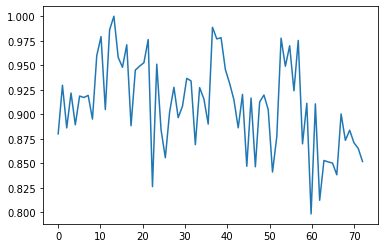

resposta =  tensor([-0.0009], grad_fn=<SelectBackward0>)
label =  tensor([0.])


In [20]:
def random_predict():
    inp = pickle.load( open( "Input_Train", "rb" ) )
    a=np.shape(inp)[0]-1
    b=np.shape(inp)[1]-1
    a_idx=rd.randint(0,a)
    b_idx=rd.randint(0,b)
    out =  pickle.load( open( "Train_Labels", "rb" ) )
    O=inp[a_idx]
    y=1*O[b_idx]
    x=np.linspace(0,len(y),len(y))
    plt.plot(x,y)
    plt.show()  
    A=out[a_idx]
    O=O.float()
    A=A.float()
    resposta = model(O)
    print('resposta = ',resposta[b_idx])
    print('label = ',A[b_idx])
random_predict()

* Label = 0 (primeira parte do gráfico)
* Label = 1 (segunda parte do gráfico)
* Se a resposta for 0 quer dizer que a rede acha que o gráfico que foi apresentado é um gráfico do inicio.
* Se a resposta for 1, a rede acha que é da segunda parte.


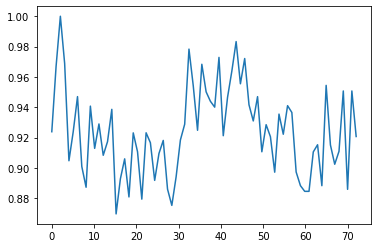

resposta =  tensor([0.0005], grad_fn=<SelectBackward0>)
label =  tensor([0.])


In [11]:
def predict_test():
    inp = pickle.load( open( "Input_test", "rb" ) )
    a=np.shape(inp)[0]-1
    b=np.shape(inp)[1]-1
    a_idx=rd.randint(0,a)
    b_idx=rd.randint(0,b)
    out =  pickle.load( open( "test_Labels", "rb" ) )
    O=inp[a_idx]
    y=1*O[b_idx]
    x=np.linspace(0,len(y),len(y))
    plt.plot(x,y)
    plt.show()  
    A=out[a_idx]
    O=O.float()
    A=A.float()
    resposta = model(O)
    print('resposta = ',resposta[b_idx])
    print('label = ',A[b_idx])
predict_test()


In [22]:
def Eval_metric():
    #inp = pickle.load( open( "Input_test", "rb" ) )
    #out =  pickle.load( open( "test_Labels", "rb" ) )
    inp = pickle.load( open( "Input_Train", "rb" ) )
    out =  pickle.load( open( "Train_Labels", "rb" ) )
    inp=inp.reshape(80,72)
    out=out.reshape(80,1)
    O=inp.float()
    A=out.float()
    resposta = model(O)
    tolerance=0.1
    erro=0
    acerto=0
    for i in range(len(resposta)):
        if abs(resposta[i])-abs(A[i])>tolerance:
            erro+=1
        else:
            acerto+=1
    print('erro = ',erro)
    print('acerto = ',acerto)

    #for j in range(np.shape(inp)[1]):
    #    y=1*O[j]
    #    x=np.linspace(0,len(y),len(y))
    #    A=out[i]
    #    O=O.float()
    #    A=A.float()
    #    resposta = model(O)

    s.exit()
    a=np.shape(inp)[0]-1
    b=np.shape(inp)[1]-1
    a_idx=rd.randint(0,a)
    b_idx=rd.randint(0,b)
    O=inp[a_idx]
    x=np.linspace(0,len(y),len(y))
    y=1*O[b_idx]
    #plt.plot(x,y)
    #plt.show()  
    A=out[a_idx]
    O=O.float()
    A=A.float()
    resposta = model(O)
    #print('resposta = ',resposta[b_idx])
    #print('label = ',A[b_idx])
Eval_metric()

erro =  0
acerto =  80


SystemExit: 

* Label = 0 (primeira parte do gráfico)
* Label = 1 (segunda parte do gráfico)
* Se a resposta for 0 quer dizer que a rede acha que o gráfico que foi apresentado é um gráfico do inicio.
* Se a resposta for 1, a rede acha que é da segunda parte.


* __Small data neural networks__

https://www.ictp.it/about-ictp/media-centre/news/2021/11/tinyml.aspx#close
* __calcular a porcentagem de erro__

* __separar o dataset em 1/4 de inicio e 1/4 de  final.__


